In [9]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import theano
import theano.tensor as tt
from fbprophet import Prophet

In [319]:
df = pd.read_csv('caracteristics.csv', encoding='latin1' )
a = pd.DataFrame(df[['jour', 'mois', 'an']].values, columns=['day', 'month', 'year'])
a['year'] += 2000
a = pd.to_datetime(a, dayfirst=True)
df['date'] = a
del a

In [337]:
df = df.groupby('date')['Num_Acc'].count()
df = df.reset_index(-1)

,y
count,4.383000e+03
mean,-4.150101e-16
std,1.000000e+00
min,-2.727780e+00
25%,-7.289615e-01
50%,-7.671536e-02
75%,6.596916e-01
max,3.794681e+00


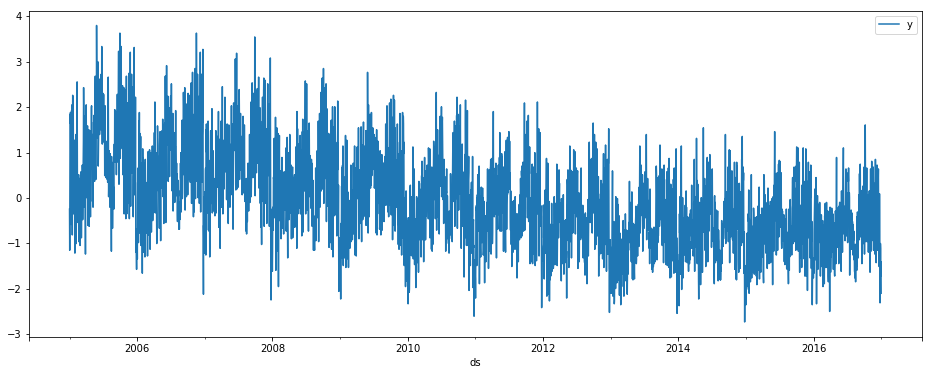

In [363]:
df = df.rename({'date': 'ds', "Num_Acc": 'y'}, axis=1)
df['y'] = (df.y - df.y.mean()) / df.y.std()
df.plot(x='ds', figsize=(16, 6))
df.describe()

,y
count,2.905000e+03
mean,-1.134912e-15
std,1.000000e+00
min,-3.400017e+00
25%,-7.378131e-01
50%,-1.666262e-01
75%,5.215514e-01
max,5.565045e+00


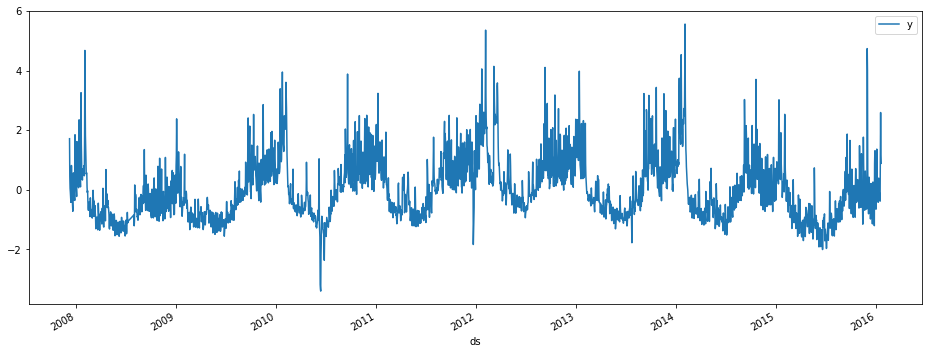

In [90]:
df = pd.read_csv('peter_manning.csv')
df.head()
df['ds'] = pd.to_datetime(df['ds'])
mean = df.y.mean()
std = df.y.std()
df['y'] = (df.y - df.y.mean()) / df.y.std()
df.plot(x='ds', figsize=(16, 6))
df.describe()


# Linear trend with changepoints
$$ g(t) = (k + a(t)^T \delta)t + (m + a(t)^T \gamma) $$

$y_j$ is set to $-s_j \delta_j$

In [4]:
np.random.seed(65)

n_changepoints = 10
t = np.arange(100)
s = np.sort(np.random.choice(t, n_changepoints))

print('Changepoints\n', s)
# All the delta up to time t are activated
a = np.zeros(n_changepoints)
a[t[50] > s] = 1

print('\nActivation vector of the changepoints delta at time t\n', a)

# we can make a matrix for all timesteps by broadcasting t and casting the booleans to integers
# array([[ 0],
#        [ 1],
#        [ 2],
#        [ 3],     >  [ 1  6 40 46 56 63 71 85 93 97]
#        [ 4],
#        [ 5],
#        [ 6]]
#        )


a = (t[:, None] > s) * 1

# result =

# array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                    .
#                    .
#                    .
#        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
#                    .
#                    .
#                    .
#         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
delta = np.random.normal(size=n_changepoints)
a @ delta

Changepoints
 [ 1  6 40 46 56 63 71 85 93 97]

Activation vector of the changepoints delta at time t
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


array([ 0.        ,  0.        ,  0.08354603,  0.08354603,  0.08354603,
        0.08354603,  0.08354603,  1.6422978 ,  1.6422978 ,  1.6422978 ,
        1.6422978 ,  1.6422978 ,  1.6422978 ,  1.6422978 ,  1.6422978 ,
        1.6422978 ,  1.6422978 ,  1.6422978 ,  1.6422978 ,  1.6422978 ,
        1.6422978 ,  1.6422978 ,  1.6422978 ,  1.6422978 ,  1.6422978 ,
        1.6422978 ,  1.6422978 ,  1.6422978 ,  1.6422978 ,  1.6422978 ,
        1.6422978 ,  1.6422978 ,  1.6422978 ,  1.6422978 ,  1.6422978 ,
        1.6422978 ,  1.6422978 ,  1.6422978 ,  1.6422978 ,  1.6422978 ,
        1.6422978 ,  0.88533636,  0.88533636,  0.88533636,  0.88533636,
        0.88533636,  0.88533636,  0.14454617,  0.14454617,  0.14454617,
        0.14454617,  0.14454617,  0.14454617,  0.14454617,  0.14454617,
        0.14454617,  0.14454617, -0.9730978 , -0.9730978 , -0.9730978 ,
       -0.9730978 , -0.9730978 , -0.9730978 , -0.9730978 , -0.95563673,
       -0.95563673, -0.95563673, -0.95563673, -0.95563673, -0.95

In [315]:
df.ds.toordinal()

AttributeError: 'Series' object has no attribute 'toordinal'

In [3]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler doen't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

In [385]:
def trend_model(m, t, n_changepoints=25, changepoints_prior_scale=0.05, growth_prior_scale=5):
    s = np.linspace(0, 0.8, n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    a = (t[:, None] > s) * 1

    with m:
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)

        # offset
        m = pm.Normal('m', 0, 5)

        k = pm.Normal('k', 0 , growth_prior_scale)

        g = (k + det_dot(a, delta)) * t + (m + det_dot(a, (-s * delta)))
    return g, a, s



In [381]:
m = pm.Model()
# timesteps
t = np.array(list(map(lambda x: x.toordinal(), df.ds.values.astype('datetime64[D]').astype('O'))))
t = (t - t.min()) / (t.max() - t.min())

with m:
    y, a, s = trend_model(m, t, changepoints_prior_scale=0.5, growth_prior_scale=5)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
                 observed=df.y)


/opt/miniconda3/lib/python3.6/site-packages/pymc3/distributions/distribution.py:424: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  shape = tuple(shape or ())


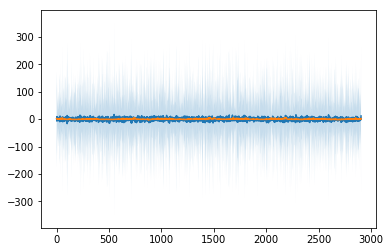

In [382]:
# Sample from the prior and check of the model is well defined.
y = pm.sample_prior_predictive(model=m, vars=['obs'])['obs']
plt.plot(y.mean(0))
plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25)
plt.plot(df.y)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
/opt/miniconda3/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/opt/miniconda3/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, k, m, delta]
INFO:pymc3:NUTS: [sigma, k, m, delta]
Sampling 4 chains: 100%|██████████| 4000/4000 [06:24<00:00,  5.87draws/s]
/opt/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_typ

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e64a8c2b0>,
      dtype=object)

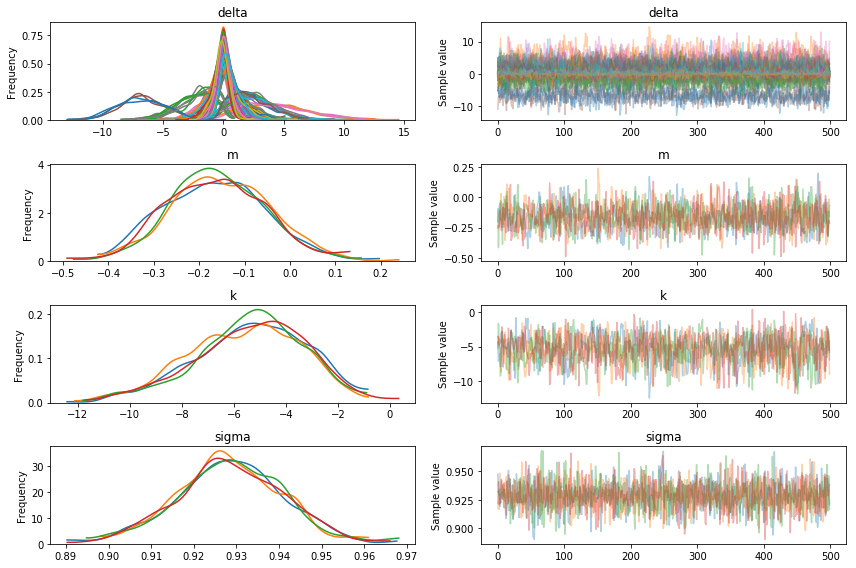

In [383]:
with m:
    trace = pm.sample(500)
    
pm.traceplot(trace)

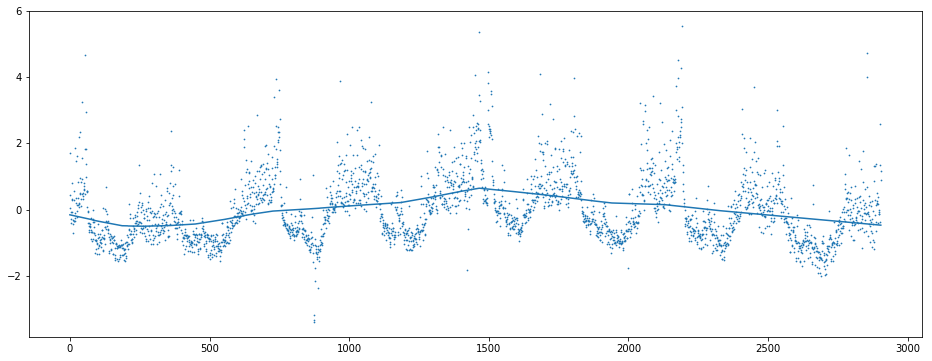

In [384]:
def det_trend(k, m, delta, t, s, a):
    return (k + np.dot(a, delta)) * t + (m + np.dot(a, (-s * delta)))

k = trace['k'].mean(-1)
m = trace['m'].mean(-1)
delta = trace['delta'].mean(0)
plt.figure(figsize=(16, 6))
plt.plot(det_trend(k, m, delta, t, s, a))
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5)

# Other linear method
inspired by https://github.com/luke14free/pm-prophet/blob/master/pmprophet/model.py


In [477]:
def trend_model(m, t, n_changepoints=25, changepoints_prior_scale=0.05):

    m = pm.Model()
    changepoint_prior_scale = 0.05
    n_changepoints = 25
    min_date = df['ds'].min()
    max_date = df['ds'].max()
    changepoints = pd.date_range(
        start=min_date,
        end=(max_date - min_date) * 0.8 + min_date,
        periods=n_changepoints + 1
    )[1:]

    with m:

        #trend
        growth = pm.Normal('growth', 0, 10)
    #     intercept = pm.Normal('intercept', df.gebruikers.mean(), sd=df.gebruikers.std())
        delta = pm.Laplace('delta', 0, changepoint_prior_scale, shape=len(changepoints))

        y = np.zeros(len(df))
    #     y += intercept
        # indexes x_i for the changepoints. 
        s = [np.abs((ds - i).values).argmin() for i in changepoints]

        g = growth
        x = t

        regression = x * g

        base_piecewise_regression = []

        for i in s:
            local_x = x.copy()[:-i]
            local_x = np.concatenate([np.zeros(i), local_x])
            base_piecewise_regression.append(local_x)

        piecewise_regression = theano.shared(np.array(base_piecewise_regression))

    #     piecewise_regression = pm.math.dot(piecewise_regression.T, d)
        piecewise_regression = (piecewise_regression.T * delta[None, :]).sum(axis=-1)
        regression += piecewise_regression

        y += regression
        
        return y, True, s

In [94]:
ds = df['ds']

m = pm.Model()
changepoint_prior_scale = 0.05
n_changepoints = 25
min_date = df['ds'].min()
max_date = df['ds'].max()
changepoints = pd.date_range(
    start=min_date,
    end=(max_date - min_date) * 0.8 + min_date,
    periods=n_changepoints + 1
)[1:]

with m:
    
    # priors
    sigma = pm.HalfCauchy('sigma', 10, testval=1)
    #trend
    growth = pm.Normal('growth', 0, 10)
#     intercept = pm.Normal('intercept', df.gebruikers.mean(), sd=df.gebruikers.std())
    prior_changepoints = pm.Laplace('changepoints', 0, changepoint_prior_scale, shape=len(changepoints))

    y = np.zeros(len(df))
#     y += intercept
    # indexes x_i for the changepoints. 
    s = [np.abs((ds - i).values).argmin() for i in changepoints]

    g = growth
    x = np.arange(len(ds))
    # delta
    d = prior_changepoints
    
    regression = x * g
    
    base_piecewise_regression = []
    
    for i in s:
        local_x = x.copy()[:-i]
        local_x = np.concatenate([np.zeros(i), local_x])
        base_piecewise_regression.append(local_x)
        
    piecewise_regression = theano.shared(np.array(base_piecewise_regression))
    
#     piecewise_regression = pm.math.dot(piecewise_regression.T, d)
    piecewise_regression = (piecewise_regression.T * d[None, :]).sum(axis=-1)
    regression += piecewise_regression
    
    y += regression
    
    obs = pm.Normal('obs',
                   mu=y,
                   sd=sigma,
                   observed=df.y)
    
#     trace = pm.sample(500, step=pm.NUTS())

/opt/miniconda3/lib/python3.6/site-packages/pymc3/distributions/distribution.py:424: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  shape = tuple(shape or ())
/opt/miniconda3/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/opt/miniconda3/lib/python3.6/site-packages/pymc3/distributions/distribution.py:424: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  shape = tuple(shape or ())


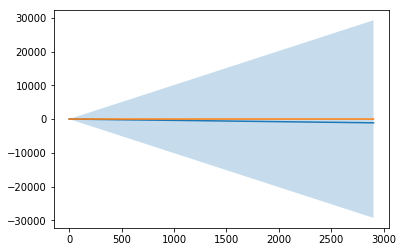

In [95]:
y = pm.sample_prior_predictive(model=m, vars=['obs'])['obs']
plt.plot(y.mean(0))
plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25)
plt.plot(df.y)

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ea059e198>,
      dtype=object)

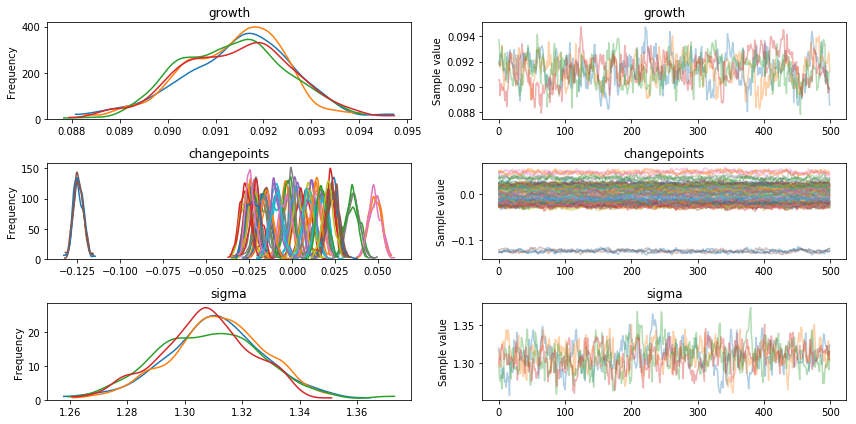

In [163]:
pm.traceplot(trace)

# Seasonality

$$ s(t) = \sum

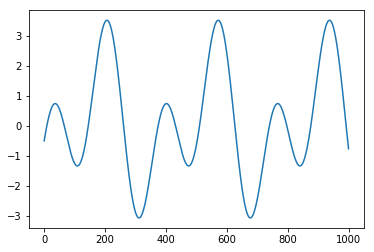

In [5]:
def fourier_series(t, p=365.25, n=10):
    x = 2 * np.pi * np.arange(1, n + 1) / p
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

n = 2
t = np.arange(1000) / 10
beta = np.random.normal(size=2 * n)

plt.plot(fourier_series(t, 365.25, n) @ beta)

In [386]:
def seasonality_model(m, t, period='yearly'):
    if period == 'yearly':
        n = 10
        p = 365.25 / (df.ds.max() - df.ds.min()).days
    else:  # weekly
        n = 3
        p = 7 / (df.ds.max() - df.ds.min()).days
    x = fourier_series(t, p, n)
    with m:
        beta = pm.Normal(f'beta_{period}', mu=0, sd=seasonality_prior_scale, shape=2 * n)
    return x, beta

m = pm.Model()
# timesteps
# t = np.arange(df.shape[0]) / df.shape[0]
t = np.array(list(map(lambda x: x.toordinal(), df.ds.values.astype('datetime64[D]').astype('O'))))
t = (t - t.min()) / (t.max() - t.min())
seasonality_prior_scale = 10
changepoints_prior_scale = 0.5
with m:
    y, a, s = trend_model(m, t, changepoints_prior_scale=changepoints_prior_scale)
    x_yearly, beta_yearly = seasonality_model(m, t, 'yearly')
    x_weekly, beta_weekly = seasonality_model(m, t, 'weekly')
    
    y += det_dot(x_yearly, beta_yearly) + det_dot(x_weekly, beta_weekly)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    obs = pm.Normal('obs', 
                 mu=y, 
                 sd=sigma,
                 observed=df.y)


/opt/miniconda3/lib/python3.6/site-packages/pymc3/distributions/distribution.py:424: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  shape = tuple(shape or ())


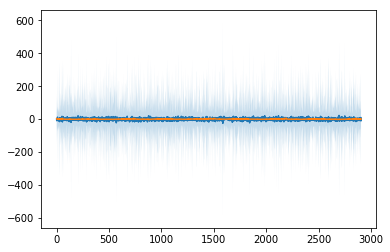

In [387]:
y = pm.sample_prior_predictive(model=m, vars=['obs'])['obs']
plt.plot(y.mean(0))
plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25)
plt.plot(df.y )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_weekly, beta_yearly, k, m, delta]
INFO:pymc3:NUTS: [sigma, beta_weekly, beta_yearly, k, m, delta]
Sampling 4 chains: 100%|██████████| 4000/4000 [09:51<00:00,  3.73draws/s]
/opt/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e63794780>,
      dtype=object)

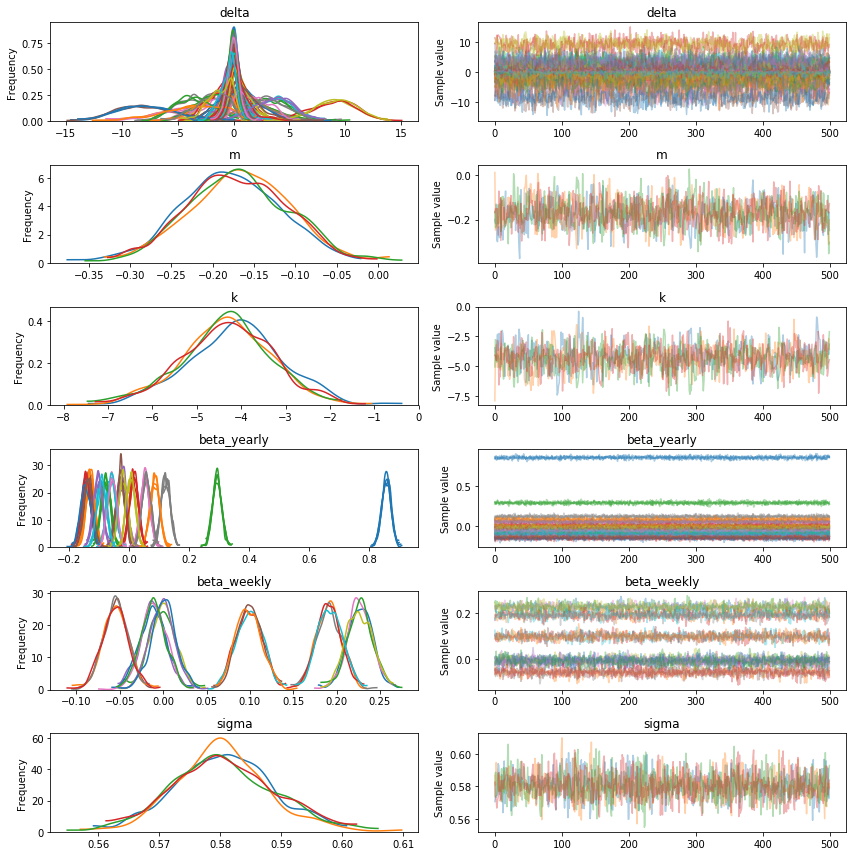

In [388]:
with m:
    trace = pm.sample(500)
pm.traceplot(trace)

In [203]:
def det_seasonality(beta, x):
    return np.dot(x, beta)

In [242]:
df.ds.shape

(2905,)

In [341]:
np.argmax(df.ds.dt.weekday)

/opt/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


6

/opt/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


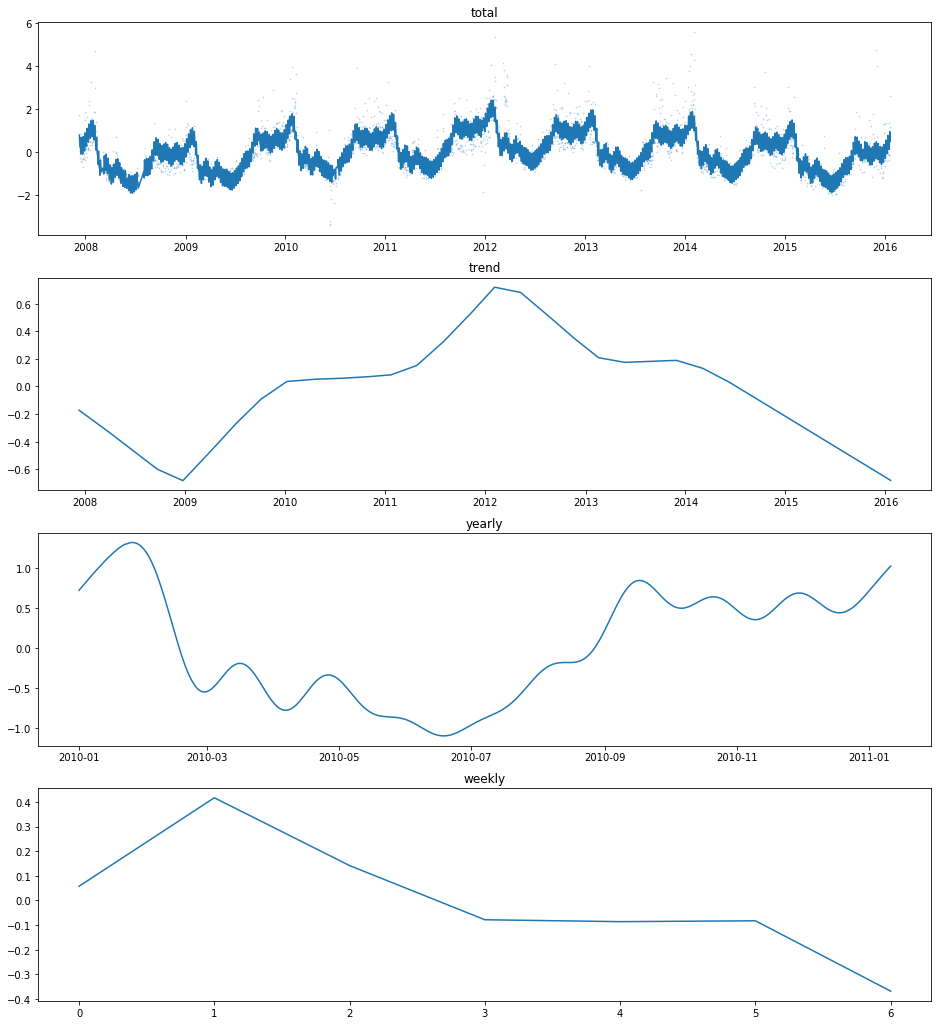

In [389]:
burn_in = 0
k = trace['k'][burn_in:].mean(-1)
m = trace['m'][burn_in:].mean(-1)
delta = trace['delta'][burn_in:].mean(0)


trend = det_trend(k, m, delta, t, s, a)
yearly = det_seasonality(trace['beta_yearly'].mean(0), x_yearly)
weekly = det_seasonality(trace['beta_weekly'].mean(0), x_weekly)

date = df.ds.values.astype('datetime64[D]').astype('O')
sunday = np.argmax(df.ds.dt.weekday)
idx_year = df.ds[df.ds == list(filter(lambda x: '01-01' in str(x), df.ds))[2]].index.values[0]

plt.figure(figsize=(16, 3*6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(date, trend + yearly + weekly)
plt.scatter(date, df.y, alpha=0.25, s=0.5)

plt.subplot(b + 1)
plt.title('trend')
plt.plot(date, trend)

plt.subplot(b + 2)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], yearly[idx_year: idx_year + 365])

plt.subplot(b + 3)
plt.title('weekly')
plt.plot(weekly[sunday: sunday + 7])

In [473]:
with m:
    aprox = pm.find_MAP()
aprox

logp = -2,852.8, ||grad|| = 23,829: : 5001it [00:06, 770.75it/s]

INFO:pymc3:


{'growth': array(0.0059549),
 'changepoints': array([-0.02270366,  0.01952374, -0.00176217,  0.00406139, -0.00935852,
         0.01077139,  0.00080391, -0.01388546,  0.00092592,  0.01746456,
        -0.01886307,  0.00658534,  0.0044668 , -0.00543467,  0.01562894,
        -0.02347049,  0.00607156,  0.00766609, -0.01285766,  0.00867445,
        -0.00016907,  0.01005663, -0.02159726,  0.01296797, -0.00247245]),
 'beta_yearly': array([ 0.31885461,  0.14842263,  0.22108169,  0.072574  ,  0.0542927 ,
         0.06262336,  0.04359232,  0.11183864, -0.0249495 , -0.00754081,
        -0.59242333,  0.19362551, -0.19851514, -0.05125736, -0.02656012,
        -0.1276854 , -0.05086521, -0.06872449,  0.04251255,  0.06893431]),
 'beta_weekly': array([ 0.04147138,  0.01747858,  0.01444503,  0.0924715 , -0.00440084,
        -0.01316864]),
 'sigma_log__': array(-0.42635657),
 'sigma': array(0.6528835)}

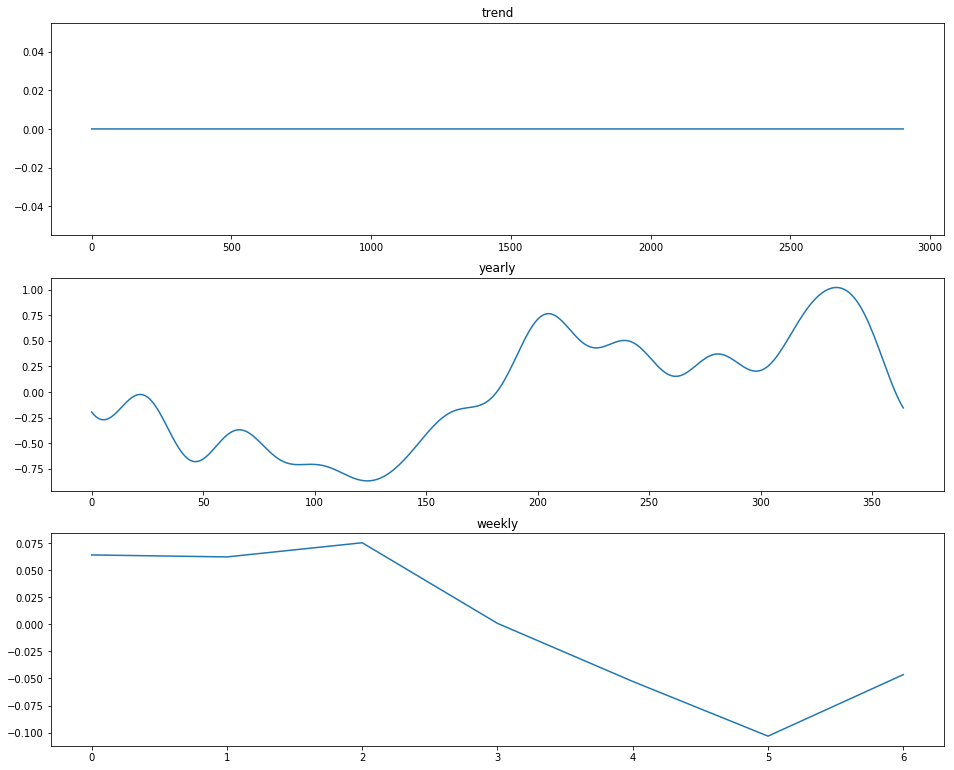

In [483]:

delta = aprox['delta']
m = aprox['m']
k = aprox['k']
yearly = aprox['beta_yearly']
weekly = aprox['beta_weekly']


trend = det_trend(k, m, delta, t, s, a)
yearly = det_seasonality(yearly, x_yearly)
weekly = det_seasonality(weekly, x_weekly)

idx_year = df.ds[df.ds == next(filter(lambda x: '01-01' in str(x), df.ds))].index.values[0]

plt.figure(figsize=(16, 3 * 6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(trend + yearly + weekly)
plt.plot(np.arange(df.shape[0]), df.y)

plt.subplot(b + 1)
plt.title('trend')
plt.plot(trend)

plt.subplot(b + 2)
plt.title('yearly')
plt.plot(yearly[idx_year: idx_year + 365])

plt.subplot(b + 3)
plt.title('weekly')
plt.plot(weekly[6: 13])

In [431]:
m = Prophet(yearly_seasonality=10, weekly_seasonality=3)
m.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/miniconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


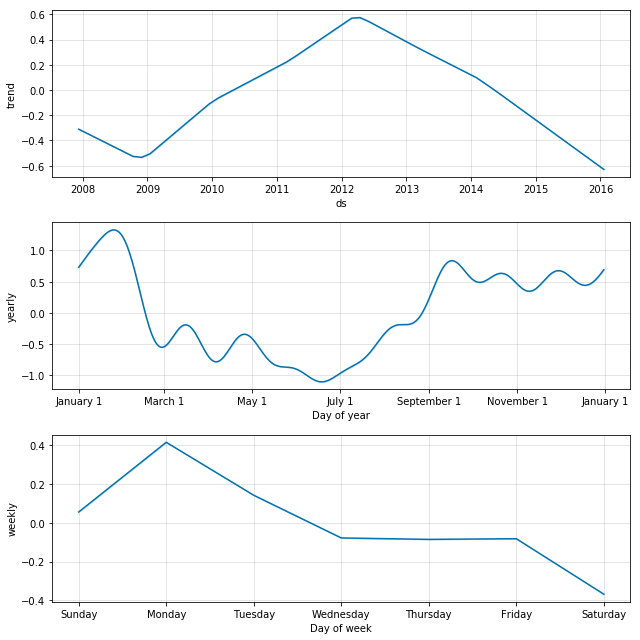

In [432]:
_ = m.plot_components(m.predict(df))